In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV




In [ ]:
# you need to add your own path to the data here
path_data = r"C:\Users\wausa\Code\rldatix\data.csv"
df = pd.read_csv(path_data)

In [4]:
df.info() # no empty 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


In [5]:
df.isna().sum() # no empty/null data points

# EDA
# patient id is not useful for ML, but merely for cross referencing


patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64

<Axes: >

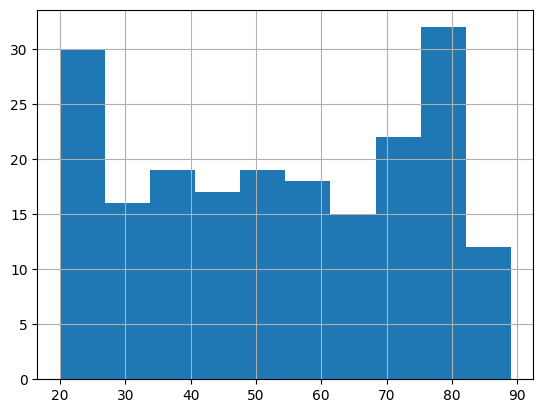

In [6]:
# age
df["age"].hist() # almost uniform distribution aside from extremes
# may want to consider transforming data, but may not be necessary

In [7]:
# gender
df["gender"].value_counts() # slightly more females than males but reasonably equivalent

gender
Female    107
Male       93
Name: count, dtype: int64

In [8]:
df["diagnosis_code"].value_counts() # diagnosis codes aren't described anywhere (unless I am mistaken), 
# all but D003 are fairly even in number so no real concerns

diagnosis_code
D001    56
D002    54
D004    53
D003    37
Name: count, dtype: int64

In [9]:
df["num_previous_admissions"].value_counts() # majority have num_previous admissions < 3, 
# may want to consider transforming to something more normally distributed 
# df["num_previous_admissions"].hist() # data is right skewed
print(f'skew of the feature is: {skew(df["num_previous_admissions"])}') # skew is 0.82, which is fairly high, ideally want it between -0.5 and

print(f'skew after log transforming is: {skew(np.log(df["num_previous_admissions"]+1))}.') # log transform but need to add value to avoid log(0), dure to the number of zero values
print(f'skew after square root transform is: {skew(np.sqrt(df["num_previous_admissions"]))}.') # square root each value to transform

# both reduce skew, log more so as it is a harsher transformation, so we will go with the log transform

df["num_previous_admissions"] = np.log(df["num_previous_admissions"]+1) # transform

skew of the feature is: 0.8210668370104314
skew after log transforming is: -0.25641787553968837.
skew after square root transform is: -0.46189618450754966.


readmitted_30_days
0    135
1     65
Name: count, dtype: int64

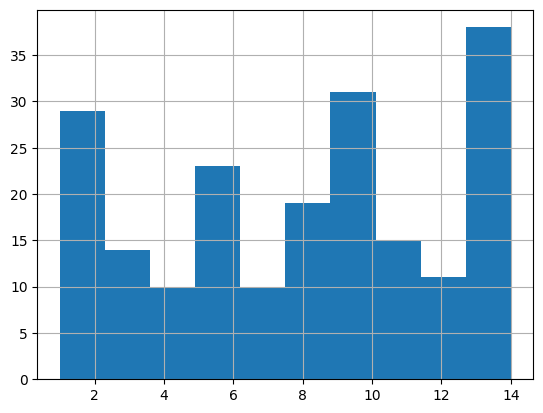

In [10]:
df["medication_type"].value_counts() # similar spread of values
df["length_of_stay"].hist() # distribution similar to age

df["discharge_note"] # is ext data, we could use a sentence encoder, or extract keywords, use word embeddings or td-idf, 
# but according to the instructions for this task we will ignore this until the second part of the task

df["readmitted_30_days"].value_counts() # target feature, is fairly skewed so we may want to consider evaluation metrics that 
# account for this skew, such as ROC-AUC 

In [11]:
# need to transform the columns gender, diagnosis cose and medication type to numerical variables, which are we required
# for machine learning. Given we have nominal/ordinal data, i.e., diagnosis code D001, D002 etc, we could just transform them into 1, 2, etc, 
# but we could use pd.get_dummies for one hot encoding but that would increase dimensionality

# pd.get_dummies(df.drop("discharge_note", axis=1))

df.info()

# convert all object columns (besides the discharge note) into encoded/numberical features
for x in df.select_dtypes(include='object').drop("discharge_note", axis=1).columns:
    df[x] = df[x].astype("category").cat.codes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   patient_id               200 non-null    int64  
 1   age                      200 non-null    int64  
 2   gender                   200 non-null    object 
 3   diagnosis_code           200 non-null    object 
 4   num_previous_admissions  200 non-null    float64
 5   medication_type          200 non-null    object 
 6   length_of_stay           200 non-null    int64  
 7   readmitted_30_days       200 non-null    int64  
 8   discharge_note           200 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 14.2+ KB


In [12]:
# check correlation matrix, no real correlation across the board
df.drop("discharge_note", axis=1).corr()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days
patient_id,1.000000,0.023048,0.022659,-0.075944,0.014877,0.103548,-0.010049,-0.087366
age,0.023048,1.000000,0.054764,-0.061027,-0.011719,0.031173,0.079308,-0.064228
gender,0.022659,0.054764,1.000000,-0.168745,-0.048753,-0.069438,-0.103177,0.037990
diagnosis_code,-0.075944,-0.061027,-0.168745,1.000000,0.081590,-0.067872,-0.020199,0.006696
num_previous_admissions,0.014877,-0.011719,-0.048753,0.081590,1.000000,-0.155102,0.072292,-0.161374
medication_type,0.103548,0.031173,-0.069438,-0.067872,-0.155102,1.000000,-0.129465,0.078826
length_of_stay,-0.010049,0.079308,-0.103177,-0.020199,0.072292,-0.129465,1.000000,0.061544
readmitted_30_days,-0.087366,-0.064228,0.037990,0.006696,-0.161374,0.078826,0.061544,1.000000


In [13]:
df

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,1,1,1.386294,2,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,0,1,0.693147,1,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,1,1,1.098612,2,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,0,1,1.098612,2,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,0,0,0.693147,2,8,1,Stable post-surgery. Advised to avoid physical...
...,...,...,...,...,...,...,...,...,...
195,196,50,1,0,1.945910,0,8,0,Good recovery trajectory. Follow-up scan sched...
196,197,61,0,3,0.693147,1,2,0,Patient discharged with minor discomfort. Advi...
197,198,26,1,1,0.000000,2,8,0,Discharge after recovery from pneumonia. No co...
198,199,35,0,0,1.386294,2,11,1,Blood pressure under control. Continue current...


In [14]:
# all columns we want to train the classifier with are numerical so we can use them for training
# I will use a simple scikit-learn random forest classifier. We do not have a lot of data (200 records), so we're not concerned about training time
# and a simple random forest classifier should give us some good results

X = df.drop(["patient_id", "readmitted_30_days", "discharge_note"], axis=1)
y = df["readmitted_30_days"]

# split the data into test_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [15]:
# intialise and train classifier

random_forest = RandomForestClassifier(max_depth=2, n_estimators=100) # can use grid search to optismise hyperparameters

random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2)

In [16]:
y_pred = random_forest.predict(X_test)


In [ ]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}") # 70% accuracy, accuray is not the best predictor as we have an imbalanced target feature
print(f"ROC_AUC score: {roc_auc_score(y_test, y_pred)}") # roc-auc -> value should be closer to 1

Accuracy score: 0.725
ROC_AUC score: 0.5


In [ ]:
importances = random_forest.feature_importances_
pd.DataFrame({"Features": X.columns, "Importance": importances})

# age is the most important, followed by number of previous admissions and length of stay

,Features,Importance
0,age,0.344592
1,gender,0.096817
2,diagnosis_code,0.081335
3,num_previous_admissions,0.264024
4,medication_type,0.074356
5,length_of_stay,0.138876


In [19]:
# Named Entity Recognition from Discharge Notes (LLM/NLP)

# import spacy
# import en_core_med7_lg # instructions here: https://github.com/kormilitzin/med7
# med7 = spacy.load("en_core_med7_lg") # load a ore trained model for entity recognition, specifically for medical usage
# I couldn't successfully import/install "en_core_med7_lg" and it was taking too long, so I went with a generic model I already had installed
# Ideally you would want to use the model specifically trained on medical data, but I will show the process but with
# a different model


In [ ]:
import spacy
import scispacy

# import en_core_web_sm
# nlp = spacy.load("en_core_web_sm")

import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")

In [88]:
doc = nlp(df["discharge_note"][0])

In [89]:
for x in doc.ents:
    print(x, x.label_)

In [ ]:
# model should label diseases, drugs, drug doses etc.
# You can use this alongside LLMs to either validate the entities that are extracted by spacy or 
# it can be used to format the layout and ensure all the required datapoints are searched for i.e., if you want 
# to produce a consistent report for each note

# Risks:
# lack of causality from model, rather than just predicting based on patterns and not considering cause and effect
# false information can be harful
# evolving medical field can be hard to keep up with